In [1]:
import pandas as pd

In [2]:
# Bring the cleaned data for the preprocessing step
df = pd.read_excel('../data/cleaned_data.xlsx', sheet_name='Sheet1', header=0)
df.head()

,x,y,char_len,word_len,clean,clean_char_len,clean_word_len
0,So there is no way for me to plug it in here i...,0,82,21,way plug u unless go converter,30,6
1,"Good case, Excellent value.",1,27,4,good case excellent value,25,4
2,Great for the jawbone.,1,22,4,great jawbone,13,2
3,Tied to charger for conversations lasting more...,0,79,11,tied charger conversation lasting 45 minute ma...,57,8
4,The mic is great.,1,17,4,mic great,9,2


In [3]:
#Now filter just the rows that are actually use for preprocessing
df = df[['clean', 'y']]
df.head()

,clean,y
0,way plug u unless go converter,0
1,good case excellent value,1
2,great jawbone,1
3,tied charger conversation lasting 45 minute ma...,0
4,mic great,1


In [4]:
#Checked for null values since in the EDA there was some 0 length entries
df.isnull().sum()

clean    1
y        0
dtype: int64

In [5]:
# See what it is out of curiosity hehe
df[df['clean'].isnull()  == True]

,clean,y
2083,NaN,0


In [6]:
# Remove all null entries (either way there was only one)
df = df[df['clean'].isnull()  == False]
df.isnull().sum()

clean    0
y        0
dtype: int64

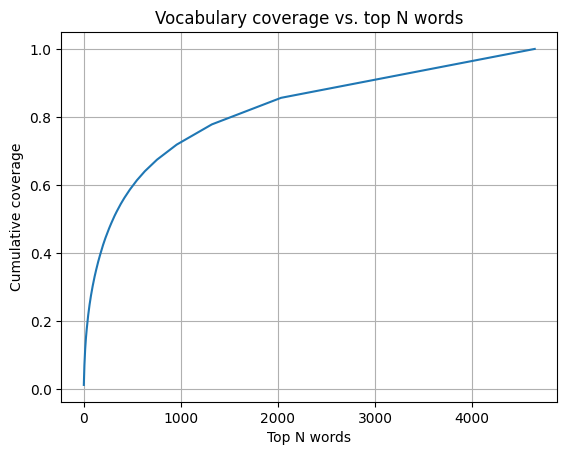

In [7]:
#I asked fo chat for a way to visualize the vocabulary coverage
# So I can decide on the max_words for the tokenizer

from collections import Counter
import matplotlib.pyplot as plt

# Tokenize all texts
all_tokens = ' '.join(df['clean']).split()
word_counts = Counter(all_tokens)

# Plot cumulative coverage
counts = sorted(word_counts.values(), reverse=True)
cumulative = [sum(counts[:i]) / sum(counts) for i in range(1, len(counts))]
plt.plot(cumulative)
plt.xlabel("Top N words")
plt.ylabel("Cumulative coverage")
plt.title("Vocabulary coverage vs. top N words")
plt.grid(True)
plt.show()

In [8]:
#Now divide split the data
from sklearn.model_selection import train_test_split

#Since the target variable has a balanced distribution, then it doesn't need to be stratified
texts_train, texts_temp, y_train, y_temp = train_test_split(df['clean'], df['y'], test_size=0.3, random_state=42)
texts_val, texts_test, y_val, y_test = train_test_split(texts_temp, y_temp, test_size=0.5, random_state=42)

#First we divide the dataset into two --> train + 30% left over
# The 30% left over, is then divided into the validation set and the train set
# The validation set it to fine tune the models
#While the test set is to see the final performance of the model

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Hágale padding a sus secuencias y obtenga aquellas para entrenamiento y aquellas para prueba

max_words = 4000 #This is from the graph above to get about 95% coverage
max_len = 44 #This is from the EDA where we used the biggest length

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(texts_train)
sequences_train = tok.texts_to_sequences(texts_train)
sequences_val = tok.texts_to_sequences(texts_val)
sequences_test = tok.texts_to_sequences(texts_test)
sequences_matrix_train = pad_sequences(sequences_train, maxlen=max_len)
sequences_matrix_val = pad_sequences(sequences_val,maxlen=max_len)
sequences_matrix_test = pad_sequences(sequences_test, maxlen=max_len)

In [10]:
#Now export the three dataframes so they can be used in the 

df_train = pd.DataFrame(sequences_matrix_train)
df_val = pd.DataFrame(sequences_matrix_val)
df_test = pd.DataFrame(sequences_matrix_test)

df_train["y"] = y_train.reset_index(drop=True)
df_val["y"] = y_val.reset_index(drop=True)
df_test["y"] = y_test.reset_index(drop=True)

with pd.ExcelWriter("../data/sequences_dataset.xlsx", engine="openpyxl") as writer:
    df_train.to_excel(writer, sheet_name="df_train", index=False)
    df_val.to_excel(writer, sheet_name="df_val", index=False)
    df_test.to_excel(writer, sheet_name="df_test", index=False)